## COVID Early Warning System Project Overview

Project goals, tools and techniques used, and data source info can be found [here](https://github.com/salvir1/covid-early-warning-system)

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import linear_model

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the COVID Tracking Project dataset by date and by state for US
covidtracking = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

df_state = covidtracking[['date', 'state', 'fips','positiveIncrease', 'deathIncrease', 'negativeIncrease']]
# df_state.info()

df_state['date'] = pd.to_datetime(df_state['date'], format='%Y%m%d')
df_state = df_state[df_state['date'] >= '2020-06-01']

st_population = pd.read_csv('../data/state_abbrev.csv', thousands=',') # Load in state population counts and merge with ctp data
df_state = df_state.merge(st_population, how='inner' ,left_on='state', right_on='Code')
# df_state.isna().sum() # No missing values!

df_state['raw_case_rate'] = df_state['positiveIncrease'] / df_state['Population'] * 100000 # normalize by population

### Threshhold charts

In [3]:
def case_rate_control_chart(ax, ST_cvd, chart_state, tick_spacing=31, scale=2.5, shift=-6, axvline_date=None):
    '''Creates a chart of raw cases as bars, 14-day MA, and estimated new infections
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    scale: rate of new infections as compared to actual diagnoses
    shift: number of days from new infection to average diagnosis recorded in data
    axvline_date: list of date ('yyyy-mm-dd'), 'comment']
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean() 
    case_upper_control_limit=ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].mean() + 2* ST_cvd[ST_cvd['date'].dt.month==8]['raw_case_rate'].std()
    case_thresh = next(x for x, val in enumerate(ST_cvd['case_SMA_14']) if val > case_upper_control_limit and x > 100) 

    ax.bar(ST_cvd['date'], ST_cvd['raw_case_rate'], label="Cases (diagnoses)", alpha = 0.3, color='darkblue')
    ax.plot(ST_cvd['date'], 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift), label="Estimated infections", color='green', alpha=0.7)
    ax.plot(ST_cvd['date'], ST_cvd['case_SMA_14'], label="Cases 14-day moving average", color='darkblue')
    ax.axhline(y=case_upper_control_limit, ls= '--', lw=1, color = 'red', label="+2 std deviations (Aug. baseline)", alpha=0.4)
    ax.axvline(x=ST_cvd['date'].iloc[case_thresh ], ls= '--', lw=1.25, color = 'red', label="Moving ave. crosses thresh.", alpha=0.75)

    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    if axvline_date:
        ax.axvline(x=ST_cvd[ST_cvd['date']==axvline_date[0]]['date'], ls= '--', lw=1.25, color = 'black', label=axvline_date[1], alpha=0.75)
    ax.set_ylim(0, 150)
    ax.set_title(f"Cases per 100,000 people for {chart_state} with threshold")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Case Rate')
    ax.legend()
    return ax

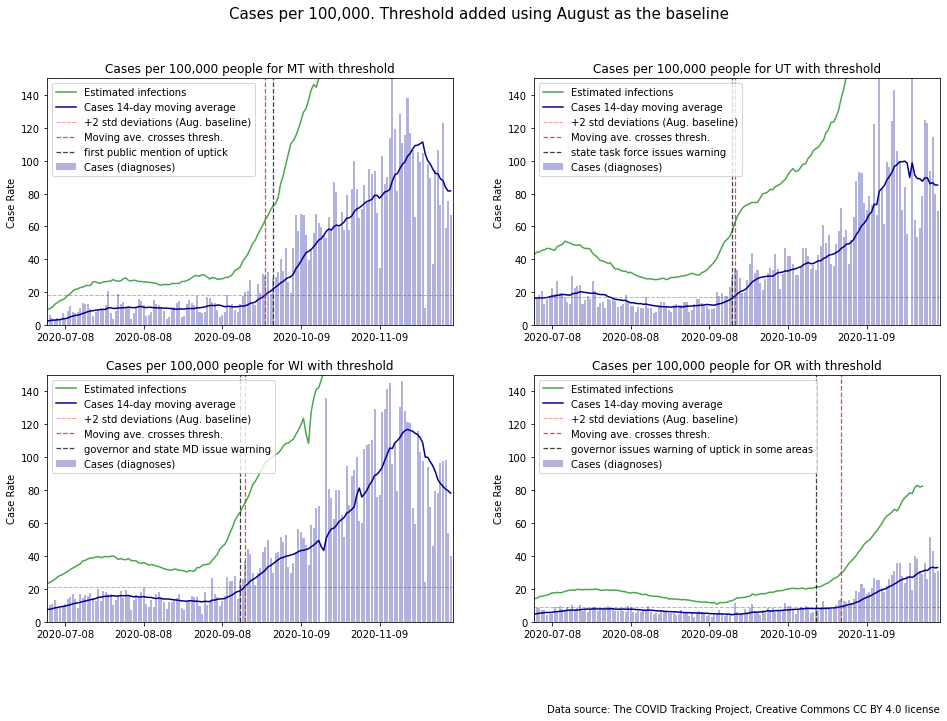

In [4]:
# Chart set: Threshold chart with state recognition of emerging outbreak

# define macro variables
infection_shift = -6 # Number of days new active infection appears before positive case enters database (negative)
tick_spacing = 31 # Display one tick per month
scale = 2.5
states_list = ['MT', 'UT', 'WI', 'WA', 'OR', 'NM']
states_list = ['MT', 'UT', 'WI', 'OR']
figs = len(states_list)
recognition_dict = {
                    'MT': ['2020-09-28', 'first public mention of uptick'],
                    'UT': ['2020-09-17', 'state task force issues warning'],
                    'WI': ['2020-09-15', 'governor and state MD issue warning'],
                    'OR': ['2020-10-20', 'governor issues warning of uptick in some areas']
#                     'OR': ['',''],
#                     'NM': ['','']
                    }

fig,axs = plt.subplots(((figs-1)//2 + 1),2,figsize=(16,(5 * ((figs-1)//2 + 1))))
fig.suptitle(f'Cases per 100,000. Threshold added using August as the baseline', size=15) # , y=0.95
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i, ax in enumerate(axs.flatten()):
    if i < len(states_list):
        ST_df = df_state[df_state['state'] == states_list[i]]
        case_rate_control_chart(ax, ST_df, states_list[i], tick_spacing, scale, infection_shift, axvline_date=recognition_dict[states_list[i]])
# plt.savefig('img/COVID-case-rate-with-threshold.png', bbox_inches = 'tight', pad_inches = 0.2)

In [5]:
def infection_random_sample(ax, ST_cvd, chart_state, tick_spacing=31, scale=2.5, shift=-6, axvline_date=None, sample_size=None):
    '''Creates a chart of a random sample from undiagnosed infections
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    scale: float, rate of new infections as compared to actual diagnoses
    shift: int, number of days from new infection to average diagnosis recorded in data
    axvline_date: [date ('yyyy-mm-dd'), 'comment']
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean() 
    ST_cvd['infections'] = 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift)
    ST_cvd['undiagnosed'] = ST_cvd['infections'] - ST_cvd['case_SMA_14']
    ST_cvd['undiagnosed_prevalence'] = (ST_cvd['undiagnosed'].rolling(min_periods=12, window=12).sum().fillna(0) + 
                ST_cvd['case_SMA_14'].rolling(min_periods=4, window=4).sum().fillna(0))
    
    # Prettify the data. Estimate missing data caused by shift using linear regression.
    regr = linear_model.LinearRegression()
    regr.fit(np.array(ST_cvd.index[-14+shift: shift]).reshape(-1,1), 
             np.array(ST_cvd['undiagnosed_prevalence'][-14+shift: shift]).reshape(-1,1))
    pred = regr.predict(np.array(ST_cvd.index[shift:]).reshape(-1,1))
    for i in range(len(pred)):
        ST_cvd['undiagnosed_prevalence'].iloc[-(-shift - i)] = pred[i]
    
    np.random.seed(15)
    ST_cvd['random_sample'] = [np.random.binomial(sample_size, 
                               (ST_cvd['undiagnosed_prevalence'].iloc[i]/100000)) for i in range(len(ST_cvd['date']))]
    august_mean = ST_cvd[ST_cvd['date'].dt.month==8]['random_sample'].mean() / sample_size
    upper_control_limit = august_mean + 2* ST_cvd[ST_cvd['date'].dt.month==8]['random_sample'].std() / sample_size

#     ax.bar(ST_cvd['date'], ST_cvd['undiagnosed_prevalence'] / 100000 - ST_cvd['random_sample'] / sample_size, label="Check normality", alpha = 0.6, color='firebrick')

    ax.plot(ST_cvd['date'], ST_cvd['undiagnosed_prevalence'] / 100000, label="Est. undiagnosed infections", color='darkgreen', alpha=0.55)
    ax.bar(ST_cvd['date'], ST_cvd['random_sample'] / sample_size, label="Simulated samples", alpha = 0.6, color='firebrick')
#     ax.axhline(y=upper_control_limit, ls= '--', lw=1, color = 'red', label="+2 std deviations (Aug. baseline)", alpha=0.5)
    if axvline_date:
        ax.axvline(x=ST_cvd[ST_cvd['date']==axvline_date[0]]['date'], ls= '--', lw=1.25, color = 'black', label=axvline_date[1], alpha=0.85)

    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    ax.set_ylim(0, 0.02)
    ax.set_title(f"Undiagnosed prevalence detection simulation for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('Undiagnosed infection prevalence')
    ax.legend()
    return ax

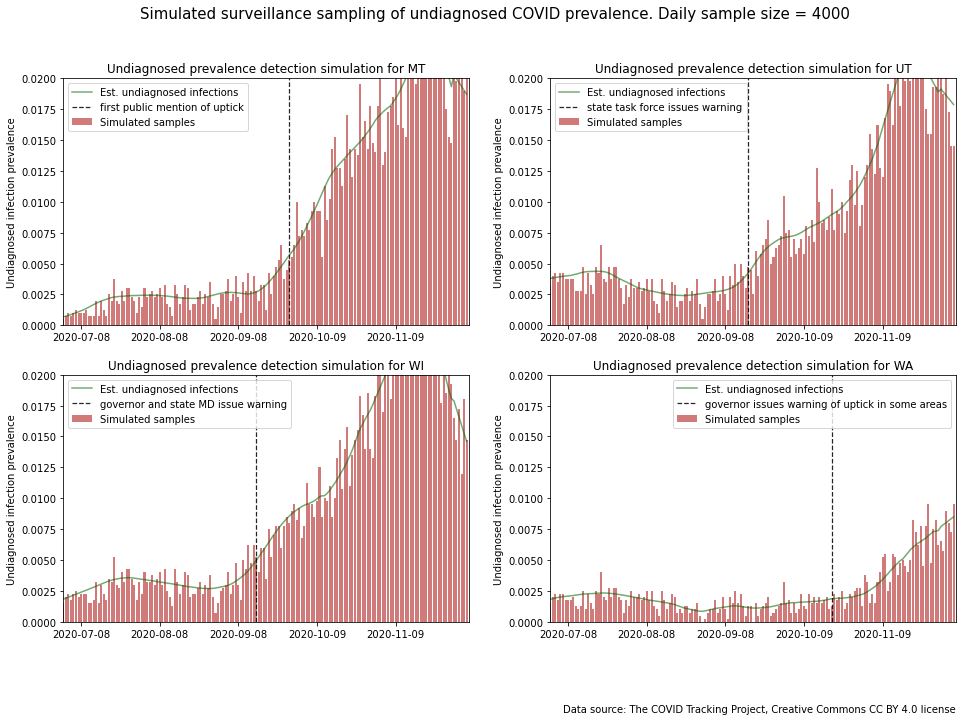

In [6]:
# Chart set: 

# define macro variables
infection_shift = -6 # Number of days new active infection appears before positive case enters database (negative)
tick_spacing = 31 # Display one tick per month
daily_sample = 4000
scale = 2.5
states_list = ['ND', 'SD', 'WI', 'OR']
states_list = ['MT', 'UT', 'WI', 'WA']
figs = len(states_list)
recognition_dict = {
                    'MT': ['2020-09-28', 'first public mention of uptick'],
                    'UT': ['2020-09-17', 'state task force issues warning'],
                    'WI': ['2020-09-15', 'governor and state MD issue warning'],
                    'WA': ['2020-10-20', 'governor issues warning of uptick in some areas'],
                    }

fig,axs = plt.subplots(((figs-1)//2 + 1),2,figsize=(16,(5 * ((figs-1)//2 + 1))))
fig.suptitle(f'Simulated surveillance sampling of undiagnosed COVID prevalence. Daily sample size = {daily_sample}', size=15) # , y=0.95
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i, ax in enumerate(axs.flatten()):
    if i < len(states_list):
        ST_df = df_state[df_state['state'] == states_list[i]]
        infection_random_sample(ax, ST_df, states_list[i], tick_spacing, scale, infection_shift, axvline_date=recognition_dict[states_list[i]], sample_size=daily_sample)
plt.savefig('img/COVID-surveillance-of-prevalence.png', bbox_inches = 'tight', pad_inches = 0.2)

In [7]:
def cusum_chart_infections(ax, ST_cvd, chart_state, tick_spacing=31, scale=2.5, shift=-6, drift=0, axvline_date=None, sample_size=None):
    '''Creates a cusum control chart of a random sample from undiagnosed infections
    Parameters
    ----------
    ax: matplotlib axis object
    ST_cvd: covid dataframe for given state
    chart_state: state name
    tick_spacing: int
    scale: float, rate of new infections as compared to actual diagnoses
    shift: int, number of days from new infection to average diagnosis recorded in data
    drift: float, allowance for positive drift in the trendline
    axvline_date: [date ('yyyy-mm-dd'), 'comment']
    Returns
    -------
    axis object
    '''
    ST_cvd['date'] = pd.to_datetime(ST_cvd['date'], format='%Y%m%d')
    ST_cvd = ST_cvd.sort_values('date', ascending=True)
    ST_cvd['case_SMA_14'] = ST_cvd['raw_case_rate'].rolling(window=14).mean() 
    ST_cvd['infections'] = 2.5 * ST_cvd['case_SMA_14'].shift(infection_shift)
    ST_cvd['undiagnosed'] = ST_cvd['infections'] - ST_cvd['case_SMA_14']
    ST_cvd['undiagnosed_prevalence'] = (ST_cvd['undiagnosed'].rolling(min_periods=12, window=12).sum().fillna(0) + 
                ST_cvd['case_SMA_14'].rolling(min_periods=4, window=4).sum().fillna(0))

    # Prettify the data. Estimate missing data caused by shift using linear regression.
    regr = linear_model.LinearRegression()
    regr.fit(np.array(ST_cvd.index[-14+shift: shift]).reshape(-1,1), 
             np.array(ST_cvd['undiagnosed_prevalence'][-14+shift: shift]).reshape(-1,1))
    pred = regr.predict(np.array(ST_cvd.index[shift:]).reshape(-1,1))
    for i in range(len(pred)):
        ST_cvd['undiagnosed_prevalence'].iloc[-(-shift - i)] = pred[i]

    np.random.seed(15)
    ST_cvd['random_sample'] = [np.random.binomial(sample_size, 
                               (ST_cvd['undiagnosed_prevalence'].iloc[i]/100000)) for i in range(len(ST_cvd['date']))]
    august_mean = ST_cvd[ST_cvd['date'].dt.month==8]['random_sample'].mean() / sample_size
    thresh_1 = august_mean + 2 * ST_cvd[ST_cvd['date'].dt.month==8]['random_sample'].std() / sample_size
    thresh_2 = august_mean + 3 * ST_cvd[ST_cvd['date'].dt.month==8]['random_sample'].std() / sample_size
    cusum_temp = 0
    cusum = np.zeros(ST_cvd['random_sample'].size)
    above_thresh1_ind = []
    above_thresh1_mrk = []
    above_thresh2_ind = []
    above_thresh2_mrk = []
    for i in range(1, len(ST_cvd['random_sample'])):
        s_ = ST_cvd['random_sample'].iloc[i] / sample_size - ST_cvd['random_sample'].iloc[i-1] / sample_size
        cusum[i] = cusum[i-1] + s_ - drift
        if cusum[i] < 0:
            cusum[i] = 0
        if cusum[i] > thresh_2:
            above_thresh2_ind.append(ST_cvd['date'].iloc[i])
            above_thresh2_mrk.append(cusum[i])
        elif cusum[i] > thresh_1:
            above_thresh1_ind.append(ST_cvd['date'].iloc[i])
            above_thresh1_mrk.append(cusum[i])
    
    ax.bar(ST_cvd['date'], cusum, label="Daily CUSUM measure", color='firebrick', alpha=0.4)
    ax.scatter(above_thresh1_ind, above_thresh1_mrk, marker='.', color = 'goldenrod')
    ax.scatter(above_thresh2_ind, above_thresh2_mrk, marker='.', color = 'red')
    ax.axhline(y=thresh_1, ls= '--', lw=1, color = 'goldenrod', label="+2 std deviations (Aug. baseline)", alpha=0.4)
    ax.axhline(y=thresh_2, ls= '--', lw=1, color = 'red', label="+ 3 std deviations (Aug. baseline)", alpha=0.4)
    if axvline_date:
        ax.axvline(x=ST_cvd[ST_cvd['date']==axvline_date[0]]['date'], ls= '--', lw=1.5, color = 'black', label=axvline_date[1], alpha=0.75)

    ax.set_xlim([datetime.date(2020, 7, 1), datetime.date.today()])
    ax.set_ylim(0, 0.02)
    ax.set_title(f"COVID prevalence detection with CUSUM monitoring for {chart_state}")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylabel('CUSUM of undiagnosed infection prevalence')
    ax.legend()
    return ax

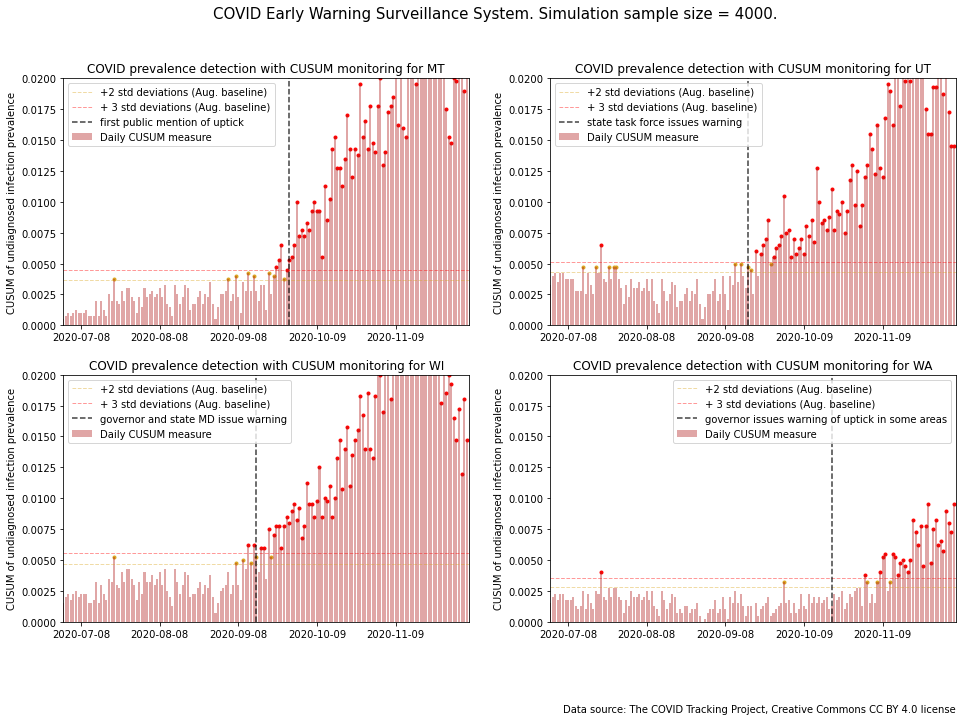

In [8]:
# Chart set: Cusum positive change chart of undiagnosed infection sampling

# define macro variables
infection_shift = -6 # Number of days new active infection appears before positive case enters database (negative)
tick_spacing = 31 # Display one tick per month
daily_sample = 4000
scale = 2.5
states_list = ['MT', 'UT', 'WI', 'WA']
figs = len(states_list)
recognition_dict = {
                    'MT': ['2020-09-28', 'first public mention of uptick'],
                    'UT': ['2020-09-17', 'state task force issues warning'],
                    'WI': ['2020-09-15', 'governor and state MD issue warning'],
                    'WA': ['2020-10-20', 'governor issues warning of uptick in some areas'],
                    }
fig,axs = plt.subplots(((figs-1)//2 + 1),2,figsize=(16,(5 * ((figs-1)//2 + 1))))
fig.suptitle(f'COVID Early Warning Surveillance System. Simulation sample size = {daily_sample}.', size=15) # , y=0.95
plt.figtext(0.9, 0, 'Data source: The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
for i, ax in enumerate(axs.flatten()):
    if i < len(states_list):
        ST_df = df_state[df_state['state'] == states_list[i]]
        cusum_chart_infections(ax, ST_df, states_list[i], tick_spacing, scale, infection_shift, axvline_date=recognition_dict[states_list[i]], sample_size=daily_sample)
plt.savefig('img/COVID-early-warning-cusum-chart.png', bbox_inches = 'tight', pad_inches = 0.2)

### Seasonality and variance analysis

In [9]:
def plot_shared_yscales(axs, x, ys, titles, state_):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(f'{state_} {title}')
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))

def plot_seasonal_decomposition(axs, series, sd, state_):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.resid, sd.seasonal],
                        ["Raw Series", "Trend Component $T_t$", "Residual Component $R_t$", "Seasonal Component $S_t$"],
                        state_)

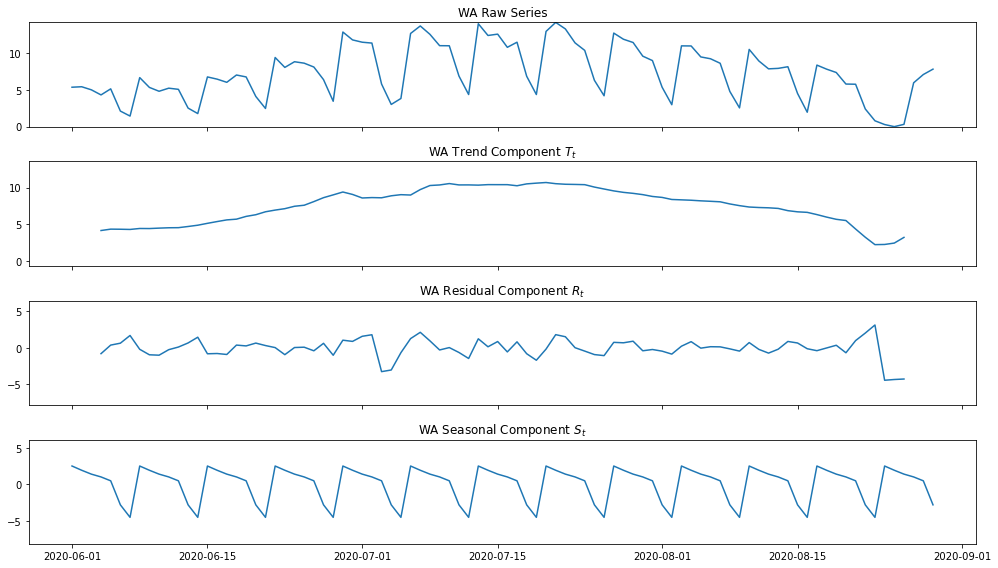

In [10]:
state_name = 'WA'
test_state = df_state[df_state['state']==state_name].set_index('date')
# Looking at decomposition through the summer
state_decomposition = sm.tsa.seasonal_decompose(test_state['raw_case_rate'].sort_index()[:90])
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, test_state['raw_case_rate'].sort_index()[:90], state_decomposition, state_name)
plt.tight_layout()

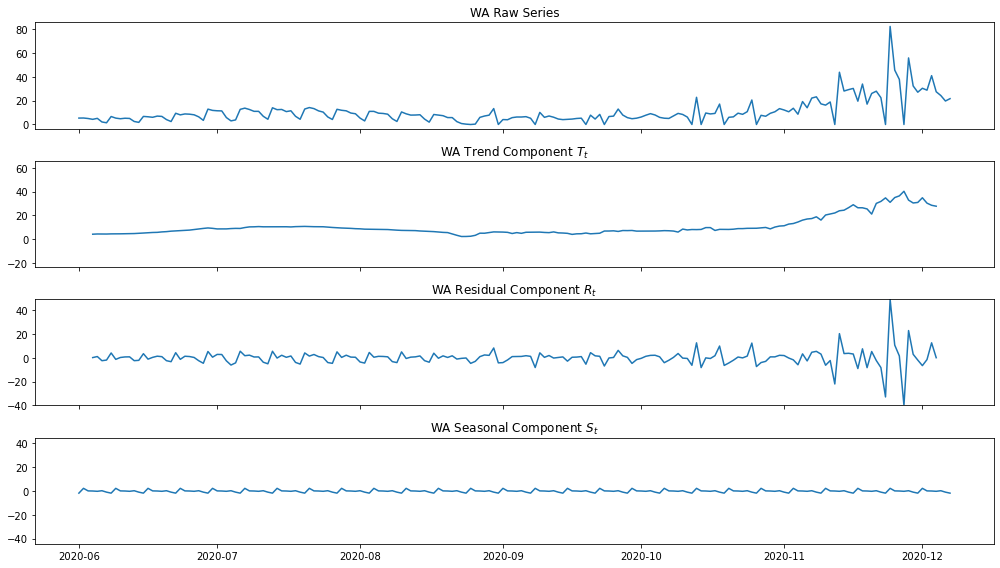

In [11]:
state_name = 'WA'
test_state = df_state[df_state['state']==state_name].set_index('date')
# Looking at decomposition up to current--note that residual compared to seasonal is much bigger
state_decomposition = sm.tsa.seasonal_decompose(test_state['raw_case_rate'].sort_index())
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
plot_seasonal_decomposition(axs, test_state['raw_case_rate'].sort_index(), state_decomposition, state_name)
plt.tight_layout()
plt.savefig('img/COVID-time-series-deconstruction.png', bbox_inches = 'tight', pad_inches = 0.2)

## An alternative approach based on random sampling

- Key metric, undiagnosed infection prevalence. An early indicator
- Many universities across the country have developed surveillance systems that rely upon daily random sampling of their students, faculty, and staff. 
- Can a similar random sampling surveillance system work at a regional level and not just in a closed population like a university?
- Such a system would face a number of logistical challenges, but would it be able to detect an outbreak as it is emerging and before it reaches the rapidly acceleration exponential phase?
- Would such a system give governments and public health experts a more accurate tool for managing the pandemic in their jurisdiction?

### Calculations and assumptions for a random sampling system

- A key question is how big the daily sample needs to be to detect a meaningful change in infection rate. The calculation requires a few steps.

- 1. **Calculate COVID prevalence.** COVID prevalence (the number of people actively infected with the disease) is  low. New diagnoses of COVID from testing programs fall into the range of  15 - 100 per 100,000 people per day. A ballpark estimate of diagnosed new infections is about 0.02% of the total susceptible population. The general literature typically states that the typical COVID infection runs about 10 days, meaning that the prevalence of diagnosed COVID cases in a susceptible population is about 0.2%. This number is an under-representation of the true prevalence since some people are asymptomatic and don't know to get tested, and others who are symptomatic choose to not get tested. It is hard to pin the size of these numbers down. Estimates range wildly. A recently published metastudy estimates the percent of asymptomatic infections to be about 20% (reference). Others who have compared the presence of antibodies with the known number of cases diagnosed suggest that as many as 9 in ten COVID infections go undiagnosed (reference). For the purposes of this analysis, it is assumed that about one-third of a population's COVID infections go undiagnosed. This would imply a prevalence of 0.3%.
 - 2. **Determine which population subset to draw the sample from.** Not everyone is equally likely to be infected by COVID. A surveillance system could be designed to take advantage of the fact that COVID is mainly transmitted from person to person through respiratory droplets, which means that a person's likelihood of acquiring and obtaining COVID increases the more one has close interaction with others. While less interactive people may ultimately be infected by someone who is more interactive, the continued spread of COVID depends on those who are highly interactive. A surveillance system could be set up to monitor people who are highly interactive including those who work in front line medicine (primary care, emergency medicine, hospital-based, nursing home-based); service industry workers (restaurant employees, grocery store front end employees, bartenders, hair stylists, those who work in salons, etc.); public safety (police, fire, EMS, airport); and younger people in general. COVID prevalence is likely to be higher in this group given that people in this group have more chances for infection. (This is especially true in the early stages of an outbreak before infections have a chance to be passed on to less interactive people). ((((( Interactivity in this group is many times higher than the rest of the population. Assume 3x as likely as general population. Make more robust.))))) This would imply overall prevalence in this population subset to be about 1%.
 
Link to WI website that shows spike in diagnoses among 18-24 preceded growth in cases across all ages across the state.
https://www.dhs.wisconsin.gov/covid-19/cases.htm#by%20age

### Version 1--Surveillance system utilizing PCR-based COVID testing

- PCR-based tests are the best tool for detecting COVID in the early stages of an infection

- A PCR-based surveillance system would be attempting to monitor active COVID infection prevalence--ideally early stage prevalence before people are likely to have sought a test. In other words, about 40% of total prevalence.
 

